In [22]:
import pandas as pd
import numpy as np
import plotly.express as px
import pymc3
import matplotlib.pyplot as plt
from plotnine import *
import itertools
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest
%matplotlib inline

df = pd.read_csv('sac_animals.csv', parse_dates=True)

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
df.outcome_type.value_counts()
df = df[df['outcome_type'].isin(['ADOPTION' ,'FOSTER', 'RTO', 'EUTH', 'TRANSFER', 'RTF', 'DIED', 'EUTH VET'])]

In [26]:
c_data = df[['animal_type', 'animal_sex_clean', 'animal_intake_status', 'name_unknown', 'has_activity_number',
            'animal_age_in_days', 'outcome_type', 'intake_type_clean', 'color_clean', 'intake_times', 'days_spent']]

c_data = c_data.dropna()
y = c_data['outcome_type']
x = c_data.drop('outcome_type', axis=1)
x = x.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=99, stratify=y)

In [28]:
x_train_res, y_train_res = SMOTE().fit_sample(x_train, y_train)

In [30]:
c_data.outcome_type.value_counts()

ADOPTION    13862
FOSTER      10376
RTO          4827
EUTH         3298
TRANSFER     1816
RTF           966
DIED          275
EUTH VET      158
Name: outcome_type, dtype: int64

In [31]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([13862,   275,  3298,   158, 10376,   966,  4827,  1816]))

In [32]:
d_tree = DecisionTreeClassifier(random_state=99)
d_tree.fit(x_train, y_train)
y_pred_tree = d_tree.predict(x_test)
target_names = ['ADOPTION', 'DIED', 'EUTH', 'EUTH VET', 'FOSTER', 'RTF', 'RTO', 'TRANSFER']
print(classification_report(y_test, y_pred_tree, target_names=target_names))

              precision    recall  f1-score   support

    ADOPTION       0.79      0.82      0.81      4575
        DIED       0.15      0.12      0.13        91
        EUTH       0.49      0.48      0.49      1088
    EUTH VET       0.16      0.12      0.13        52
      FOSTER       0.78      0.78      0.78      3424
         RTF       0.64      0.59      0.62       319
         RTO       0.69      0.69      0.69      1593
    TRANSFER       0.39      0.35      0.37       599

    accuracy                           0.72     11741
   macro avg       0.51      0.49      0.50     11741
weighted avg       0.72      0.72      0.72     11741



In [33]:
rf = RandomForestClassifier(random_state=99)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

    ADOPTION       0.81      0.84      0.83      4575
        DIED       0.23      0.08      0.11        91
        EUTH       0.57      0.51      0.54      1088
    EUTH VET       0.25      0.12      0.16        52
      FOSTER       0.78      0.81      0.80      3424
         RTF       0.68      0.66      0.67       319
         RTO       0.73      0.74      0.74      1593
    TRANSFER       0.48      0.40      0.44       599

    accuracy                           0.75     11741
   macro avg       0.57      0.52      0.54     11741
weighted avg       0.74      0.75      0.75     11741



<AxesSubplot:xlabel='feature', ylabel='importance'>

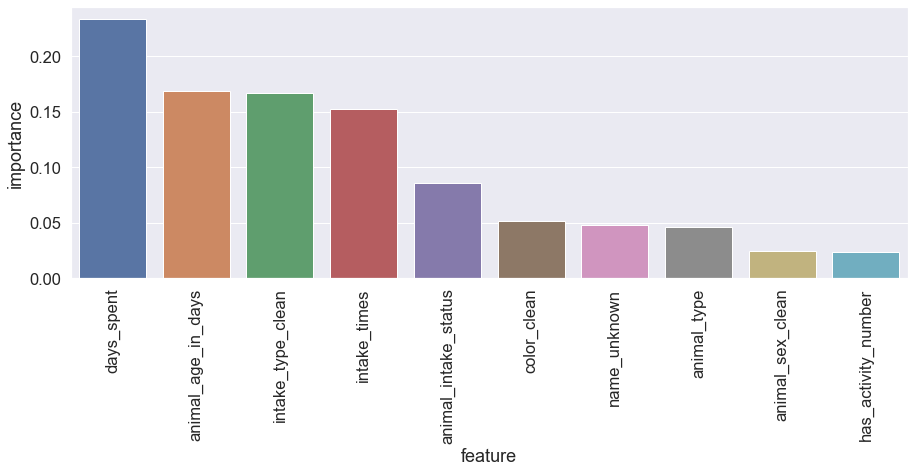

In [34]:
feature_importances = rf.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': x_train_res.columns}, 
                           index=x_train_res.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

In [35]:
criterion = ['gini', 'entropy']
components = [175, 200, 225]
estimators = [100, 250, 500]
k = [10, 15, 20]
cv = StratifiedKFold(3)

In [36]:
rf = RandomForestClassifier(class_weight='balanced_subsample', bootstrap=True, oob_score=True)

rf_gridcv = GridSearchCV(estimator=rf, param_grid=dict(n_estimators=estimators, 
                                                     criterion=criterion), 
                         scoring='accuracy', cv=cv, return_train_score=True)

rf_gridcv.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              oob_score=True),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 250, 500]},
             return_train_score=True, scoring='accuracy')

In [37]:
results = pd.DataFrame(rf_gridcv.cv_results_)
results.sort_values(by='rank_test_score', ascending=True, inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
5,6.720930,0.015750,0.546675,0.007151,entropy,500,"{'criterion': 'entropy', 'n_estimators': 500}",0.732696,0.737226,0.727376,0.732433,0.004026,1,0.917878,0.920647,0.921155,0.919893,0.001440
1,3.213025,0.030105,0.290366,0.015369,gini,250,"{'criterion': 'gini', 'n_estimators': 250}",0.732570,0.738107,0.725991,0.732223,0.004952,2,0.917312,0.921717,0.921470,0.920166,0.002021
0,1.311937,0.018352,0.120066,0.002997,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.734458,0.736094,0.725991,0.732181,0.004427,3,0.918004,0.920206,0.921659,0.919956,0.001503
2,6.214030,0.077489,0.544073,0.004183,gini,500,"{'criterion': 'gini', 'n_estimators': 500}",0.734080,0.735590,0.726621,0.732097,0.003921,4,0.918004,0.920395,0.921722,0.920040,0.001538
3,1.403015,0.044368,0.116269,0.004023,entropy,100,"{'criterion': 'entropy', 'n_estimators': 100}",0.733702,0.736597,0.725362,0.731887,0.004763,5,0.919011,0.920836,0.920274,0.920040,0.000763


In [38]:
rf_grid_pred = rf_gridcv.predict(x_test)
print(classification_report(y_test, rf_grid_pred, target_names=target_names))

              precision    recall  f1-score   support

    ADOPTION       0.82      0.81      0.82      4575
        DIED       0.14      0.20      0.17        91
        EUTH       0.53      0.49      0.51      1088
    EUTH VET       0.16      0.29      0.21        52
      FOSTER       0.79      0.79      0.79      3424
         RTF       0.64      0.71      0.67       319
         RTO       0.72      0.74      0.73      1593
    TRANSFER       0.42      0.41      0.42       599

    accuracy                           0.73     11741
   macro avg       0.53      0.55      0.54     11741
weighted avg       0.74      0.73      0.74     11741



Normalized confusion matrix


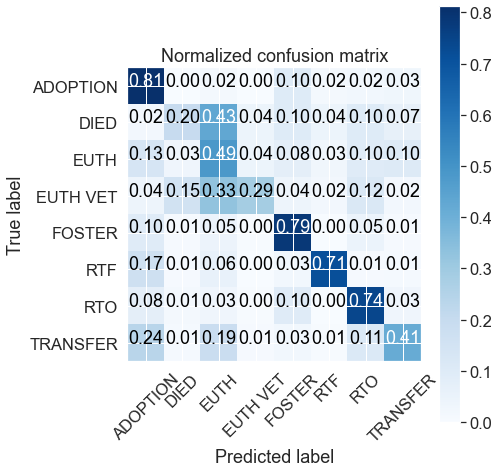

In [39]:
plt.figure(figsize=(7, 7))
rf_cnf_mat = confusion_matrix(y_test, rf_grid_pred)
plot_confusion_matrix(rf_cnf_mat, classes=target_names, normalize=True, title='Normalized confusion matrix')

In [41]:
gb_c = GradientBoostingClassifier()
gb_c.fit(x_train_res, y_train_res)
y_pred_gbc = gb_c.predict(x_test)
print(classification_report(y_test, y_pred_gbc, target_names=target_names))

              precision    recall  f1-score   support

    ADOPTION       0.86      0.77      0.81      4575
        DIED       0.11      0.44      0.17        91
        EUTH       0.51      0.36      0.42      1088
    EUTH VET       0.12      0.62      0.20        52
      FOSTER       0.79      0.78      0.79      3424
         RTF       0.51      0.89      0.65       319
         RTO       0.73      0.76      0.74      1593
    TRANSFER       0.48      0.51      0.49       599

    accuracy                           0.72     11741
   macro avg       0.51      0.64      0.54     11741
weighted avg       0.75      0.72      0.73     11741



In [46]:
df['outcome_type_clean'] = df['outcome_type']
df.loc[df['outcome_type_clean'].isin(['DIED', 'EUTH', 'EUTH VET']), 'outcome_type_clean'] = 'DIED'

c_data = df[['animal_type', 'animal_sex_clean', 'animal_intake_status', 'name_unknown', 'has_activity_number',
            'animal_age_in_days', 'outcome_type_clean', 'intake_type_clean', 'color_clean', 'intake_times', 'days_spent']]

c_data = c_data.dropna()
y = c_data['outcome_type_clean']
x = c_data.drop('outcome_type_clean', axis=1)
x = x.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=99, stratify=y)
target_names = ['ADOPTION', 'DIED', 'FOSTER', 'RTF', 'RTO', 'TRANSFER']

rf = RandomForestClassifier(class_weight='balanced_subsample', bootstrap=True, oob_score=True)

rf_gridcv = GridSearchCV(estimator=rf, param_grid=dict(n_estimators=estimators, 
                                                     criterion=criterion), 
                         scoring='accuracy', cv=cv, return_train_score=True)

rf_gridcv.fit(x_train, y_train)

rf_grid_pred = rf_gridcv.predict(x_test)
print(classification_report(y_test, rf_grid_pred, target_names=target_names))

              precision    recall  f1-score   support

    ADOPTION       0.82      0.81      0.82      4575
        DIED       0.58      0.62      0.60      1231
      FOSTER       0.79      0.78      0.79      3424
         RTF       0.66      0.73      0.69       319
         RTO       0.73      0.72      0.73      1593
    TRANSFER       0.42      0.40      0.41       599

    accuracy                           0.75     11741
   macro avg       0.67      0.68      0.67     11741
weighted avg       0.75      0.75      0.75     11741



Normalized confusion matrix


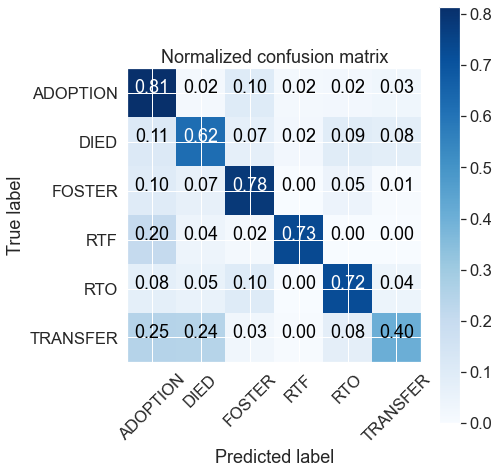

In [48]:
plt.figure(figsize=(7, 7))
rf_cnf_mat = confusion_matrix(y_test, rf_grid_pred)
plot_confusion_matrix(rf_cnf_mat, classes=target_names, normalize=True, title='Normalized confusion matrix')